In [211]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

from catboost import CatBoostClassifier, Pool

from scipy.stats import pearsonr

from confusion_matrix import plot_confusion_matrix

In [150]:
# Plots stuff
from pylab import rcParams
rcParams['figure.figsize'] = 8, 8
%matplotlib inline
sns.set()
plt.rcParams['figure.dpi'] = 100

# Data import

In [6]:
ade_raw_df = pd.read_spss('antipsychotics_safety.sav')

In [7]:

import pyreadstat
ade_raw_df, meta = pyreadstat.read_sav('antipsychotics_safety.sav')
ade_raw_df.head(5)

,ID,Отделение,Пол,Возраст,Срок_госп,Диагноз_1,Диагноз_2,Др_диагнозы,Все_госп,Длит_заболев,...,НПР_всего,АП_1_Тип,АП_2_Тип,АП_3_Тип,AP_1_Off,AP_2_Off,AP_3_Off,NT_Off,AD_Off,Off_Rate
0,1.0,3.0,2.0,17.0,65.0,1.0,1.0,0.0,2.0,36.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,2.0,4.0,1.0,15.0,202.0,1.0,4.0,0.0,1.0,0.0,...,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,3.0,3.0,2.0,14.0,89.0,1.0,1.0,0.0,1.0,1.0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,5.0,2.0,14.0,60.0,10.0,1.0,0.0,1.0,2.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,6.0,1.0,8.0,24.0,1.0,7.0,0.0,2.0,15.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [9]:
list(zip(ade_raw_df.columns, meta.column_labels))

[('ID', None),
 ('Отделение', None),
 ('Пол', None),
 ('Возраст', None),
 ('Срок_госп', 'Срок госпитализации (дни)'),
 ('Диагноз_1', 'Диагноз при поступлении'),
 ('Диагноз_2', 'Диагноз при выписке'),
 ('Др_диагнозы', 'Сопутствующие диагнозы'),
 ('Все_госп', 'Общее число госпитализаций (включая настоящую)'),
 ('Длит_заболев', 'Длительность заболевания (мес)'),
 ('Вед_синдром', 'Ведущий синдром'),
 ('АП_1', 'Первый применяемый антипсихотик'),
 ('АП_1_старт', 'Стартовая доза первого антипсихотика (мг/сут)'),
 ('АП_1_Макс', 'Максимальная доза первого антипсихотика (мг/сут)'),
 ('АП_1_Подд', 'Поддерживающая доза первого антипсихотика (мг/сут)'),
 ('АП_1_старт_экв',
  'Первый антипсихотик, стартовая доза (аминазиновый эквивалент, мг/сут)'),
 ('АП_1_макс_экв',
  'Первый антипсихотик, максимальная доза (аминазиновый эквивалент, мг/сут)'),
 ('АП_1_подд_экв',
  'Первый антипсихотик, поддерживающая доза (аминазиновый эквивалент, мг/сут)'),
 ('АП_1_Отм', 'Факт отмены первого антипсихотика'),
 ('АП

In [10]:
TARGET_COLS = [col for col in ade_raw_df.columns if col.startswith('НПР')]
TARGET_COLS

['НПР_Антигист',
 'НПР_рвота',
 'НПР_лейк',
 'НПР_седация',
 'НПР_сыпь',
 'НПР_отмена',
 'НПР_доза',
 'НПР_запор',
 'НПР_Рацио',
 'НПР_госпит',
 'НПР_ЭПС',
 'НПР_факт',
 'НПР_всего']

In [12]:
ade_raw_df[TARGET_COLS].describe()

,НПР_Антигист,НПР_рвота,НПР_лейк,НПР_седация,НПР_сыпь,НПР_отмена,НПР_доза,НПР_запор,НПР_Рацио,НПР_госпит,НПР_ЭПС,НПР_факт,НПР_всего
count,450.000000,450.000000,450.0,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000
mean,0.008889,0.002222,0.0,0.013333,0.006667,0.055556,0.013333,0.002222,0.002222,0.015556,0.200000,0.280000,0.320000
std,0.093965,0.047140,0.0,0.114825,0.081468,0.229316,0.114825,0.047140,0.047140,0.123886,0.400445,0.449499,0.546134
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [14]:
ade_raw_df[TARGET_COLS].sum(axis=0)

НПР_Антигист      4.0
НПР_рвота         1.0
НПР_лейк          0.0
НПР_седация       6.0
НПР_сыпь          3.0
НПР_отмена       25.0
НПР_доза          6.0
НПР_запор         1.0
НПР_Рацио         1.0
НПР_госпит        7.0
НПР_ЭПС          90.0
НПР_факт        126.0
НПР_всего       144.0
dtype: float64

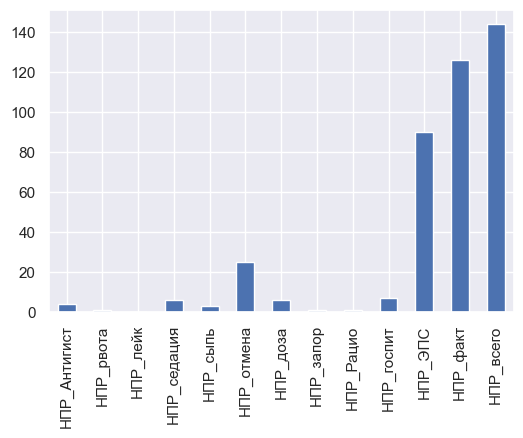

In [22]:
ade_raw_df[TARGET_COLS].sum(axis=0).plot(kind='bar')

In [25]:
ade_raw_df['T18_НПР'].describe()

count    450.000000
mean       0.202222
std        1.032434
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       10.000000
Name: T18_НПР, dtype: float64

In [26]:
ade_raw_df['T18_НПР'].unique()

array([ 0.,  1.,  5.,  2.,  3.,  6.,  4.,  7.,  8.,  9., 10.])

In [222]:
v_c = ade_raw_df['АП_1_Отм_пр'].value_counts()
v_c.index = v_c.index.map(meta.variable_value_labels['АП_1_Отм_пр'])
v_c

Не отменялся         248
Неэффективность      119
Без обоснования       43
Наличие НПР           39
Нет необходимости      1
Name: АП_1_Отм_пр, dtype: int64

In [223]:
v_c = ade_raw_df['АП_2_Отм_пр'].value_counts()
v_c.index = v_c.index.map(meta.variable_value_labels['АП_2_Отм_пр'])
v_c

Не отменялся         376
Без обоснования       34
Неэффективность       22
Наличие НПР           12
Нет необходимости      6
Name: АП_2_Отм_пр, dtype: int64

In [224]:
v_c = ade_raw_df['АП_3_отм_пр'].value_counts()
v_c.index = v_c.index.map(meta.variable_value_labels['АП_3_отм_пр'])
v_c

Не отменялся       438
Без обоснования      7
Неэффективность      3
Наличие НПР          2
Name: АП_3_отм_пр, dtype: int64

In [46]:
ade_raw_df.dropna(axis=1).columns

Index(['ID', 'Отделение', 'Пол', 'Возраст', 'Срок_госп', 'Диагноз_1',
       'Диагноз_2', 'Др_диагнозы', 'Все_госп', 'Вед_синдром',
       ...
       'НПР_всего', 'АП_1_Тип', 'АП_2_Тип', 'АП_3_Тип', 'AP_1_Off', 'AP_2_Off',
       'AP_3_Off', 'NT_Off', 'AD_Off', 'Off_Rate'],
      dtype='object', length=149)

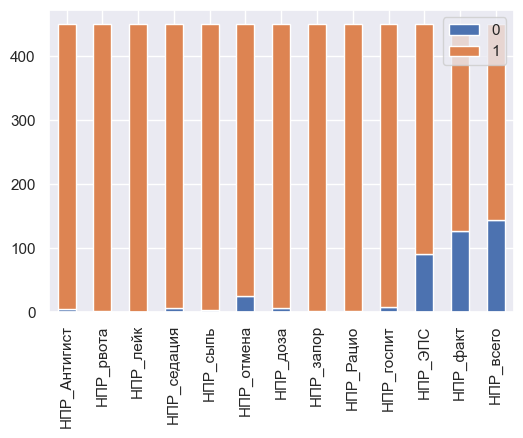

In [53]:
pd.DataFrame(
    [ade_raw_df[TARGET_COLS].sum(axis=0), ade_raw_df.shape[0] -
     ade_raw_df[TARGET_COLS].sum(axis=0)]
).T.plot(kind='bar', stacked=True)

# X & Y generation

In [132]:
Y = ade_raw_df['НПР_факт']
Y.describe()

count    450.000000
mean       0.280000
std        0.449499
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: НПР_факт, dtype: float64

In [183]:
NON_PREDICTOR_COLS = np.array([
    'ID',
    'Отделение',
    'T18',
    'T18_НПР',
    'T18_причина',
    'T19',
    'T19_НПР',
    'T19_причина',
    'T22',
    'T25',
    'Т25_причина',
    'T30',
    'Т16_вредНПР',
    'Т16_предотврНПР',
    'Т16_типНПР',
    'Т16_Наранжо',
    'Т17_Причина',
    'T17_вредНПР',
    'T17_предотврНПР',
    'T17_типНПР',
    'T17_Наранжо',
    'Т18_вредНПР',
    'Т18_предотврНПР',
    'Т18_типНПР',
    'Т18_Наранжо',
    'T19_вредНПР',
    'Т19_предотврНПР',
    'Т19_типНПР',
    'Т19_Наранжо',
    'Т25_вредНПР',
    'Т25_предовтрНПР',
    'Т25_типНПР',
    'Т25_Наранжо',
    'Т1_1_вредНПР',
    'Т1_1_предотврНПР',
    'Т1_1_типНПР',
    'Т1_1_Наранжо',
    'Т4_вредНПР',
    'Т4_предотврНПР',
    'Т4_типНПР',
    'Т4_Наранжо',
    'T1_Причина',
    'T1_вредНПР',
    'T1_предотврНПР',
    'T1_типНПР',
    'T1_Наранжо',
    'T30_Описание',
    'T30_вредНПР',
    'T30_предотврНПР',
    'T30_типНПР',
    'T30_Наранжо',
    'НПР_Антигист',
    'НПР_рвота',
    'НПР_лейк',
    'НПР_седация',
    'НПР_сыпь',
    'НПР_отмена',
    'НПР_доза',
    'НПР_запор',
    'НПР_Рацио',
    'НПР_госпит',
    'НПР_ЭПС',
    'НПР_факт',
    'НПР_всего',
    # Possibly should be included into main analysis
    'ЭПС_причина',
    'ЭПС_Вред_НПР',
    'ЭПС_Предотвр_НПР',
    'ЭПС_Тип_НПР',
    'ЭПС_Шкала_Наранжо',
])

CATEGORICAL_COLS = np.array([
    'Диагноз_1',
    'Диагноз_2',
    'Др_диагнозы',
    'Вед_синдром',
    'АП_1',
    'АП_1_Отм',
    'АП_1_Отм_пр',
    'АП_2',
    'АП_2_Отм',
    'АП_2_Отм_пр',
    'АП_3',
    'АП_3_отм',
    'АП_3_отм_пр',
    'АП_сед',
    'АП_сед_отм',
    'АП_сед_отм_пр',
    'АД',
    'АД_отм',
    'АД_отм_пр',
    'НТ',
    'НТ_отм',
    'НТ_отм_пр',
    'Транк',
    'Корректор',
    'Отмена_корр',
    'T1',
    'Т4',
    'ЭПС',
#     'ЭПС_причина',
#     'ЭПС_Вред_НПР',
#     'ЭПС_Предотвр_НПР',
#     'ЭПС_Тип_НПР',
#     'ЭПС_Шкала_Наранжо',
])

In [172]:
X = ade_raw_df.drop(columns=NON_PREDICTOR_COLS)
X[CATEGORICAL_COLS] = X[CATEGORICAL_COLS].astype(int)
# Synthetic cols
X['Psych_drugs_count'] = (
    X['АП_1'].astype(bool).astype(int) + X['АП_2'].astype(bool).astype(int) + X['АП_3'].astype(bool).astype(int) +
    X['АП_сед'].astype(bool).astype(int) + X['АД'].astype(bool).astype(int) + X['НТ'].astype(bool).astype(int) + X['ЭПС'].astype(bool).astype(int)
)

X['Extra_AP_drugs'] = X['АП_2'].astype(bool) | X['АП_3']


X.describe()

,Пол,Возраст,Срок_госп,Диагноз_1,Диагноз_2,Др_диагнозы,Все_госп,Длит_заболев,Вед_синдром,АП_1,...,АП_1_Тип,АП_2_Тип,АП_3_Тип,AP_1_Off,AP_2_Off,AP_3_Off,NT_Off,AD_Off,Off_Rate,Psych_drugs_count
count,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,276.000000,450.000000,450.000000,...,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000
mean,1.504444,14.515556,59.364444,7.666667,10.448889,0.255556,1.591111,9.668478,3.680000,4.104444,...,1.231111,0.484444,0.600000,0.084444,0.068889,0.093333,0.264444,0.008889,0.520000,3.997778
std,0.500537,2.208705,31.088502,9.677886,9.732654,1.235708,1.060282,11.107641,1.536432,8.730319,...,0.422012,0.728655,0.814676,0.278363,0.253547,0.291223,0.441528,0.093965,0.694105,1.337316
min,1.000000,7.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,13.000000,39.000000,1.000000,3.000000,0.000000,1.000000,2.000000,3.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
50%,2.000000,15.000000,53.000000,2.000000,8.000000,0.000000,1.000000,6.000000,3.000000,2.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,2.000000,16.000000,72.750000,11.000000,16.750000,0.000000,2.000000,12.250000,4.000000,5.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,5.000000
max,2.000000,17.000000,212.000000,41.000000,38.000000,9.000000,9.000000,72.000000,9.000000,102.000000,...,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,7.000000


In [191]:
# ade_raw_df['T1'].describe()
meta.variable_value_labels['ЭПС_причина']

{0.0: 'Нет НПР',
 1.0: 'Назначено несколько антипсихотиков',
 2.0: 'Галоперидол',
 3.0: 'Трифлуоперазин',
 4.0: 'Зуклопентиксол',
 5.0: 'Рисперидон',
 6.0: 'Хлорпротиксен',
 7.0: 'Флупентиксол',
 8.0: 'Хлорпромазин',
 9.0: 'Перфеназин'}

# Important features plot logic

In [174]:
def plot_important_features(X, coefficients, name, normalize=True):
    ##### TOP MOST IMPORTANT FEATURES PLOT

    N_to_print = min(20, X.shape[1]) # Plot up to 20 most important features
    y_pos = range(N_to_print)
    fig, ax = plt.subplots()
    plt.figure(figsize=(10,7))

    feature_importance = coefficients.round(4)
    feature_importance = zip(X.keys(), feature_importance)
    feature_importance = np.array(sorted(
        map(
            lambda pair: pair[1] != abs(pair[1]) and ('[negative]' + pair[0], abs(pair[1])) or (pair[0], pair[1]),
            feature_importance
        ),
        key=lambda x:x[1], reverse=True))
    ax.barh(y_pos, feature_importance[:N_to_print, 1].astype('float'), align='center', color='green')
    ax.set_yticks(np.arange(N_to_print))
    ax.set_yticklabels(feature_importance[:N_to_print, 0])
    ax.invert_yaxis()
    ax.set_xlabel(f'Importance/coefficients for {name}')

    plt.show()

# ROC AUC Curve plot logic

In [175]:
def plot_roc_auc_curve(classifier, cv, X, y):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(8)
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = plot_roc_curve(classifier, X[test], y[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic example")
    ax.legend(loc="lower right")
    plt.show()



# Binary classification using CatBoost model

0:	learn: 0.3006360	total: 2.82ms	remaining: 2.82ms
1:	learn: 0.2697491	total: 4.75ms	remaining: 0us
0:	learn: 0.2569428	total: 4.78ms	remaining: 4.78ms
1:	learn: 0.2099390	total: 8.55ms	remaining: 0us
0:	learn: 0.2854188	total: 2.23ms	remaining: 2.23ms
1:	learn: 0.2564857	total: 4.56ms	remaining: 0us
0:	learn: 0.2635011	total: 2.33ms	remaining: 2.33ms
1:	learn: 0.2625556	total: 4.42ms	remaining: 0us
0:	learn: 0.2409275	total: 5.48ms	remaining: 5.48ms
1:	learn: 0.2198967	total: 9.04ms	remaining: 0us


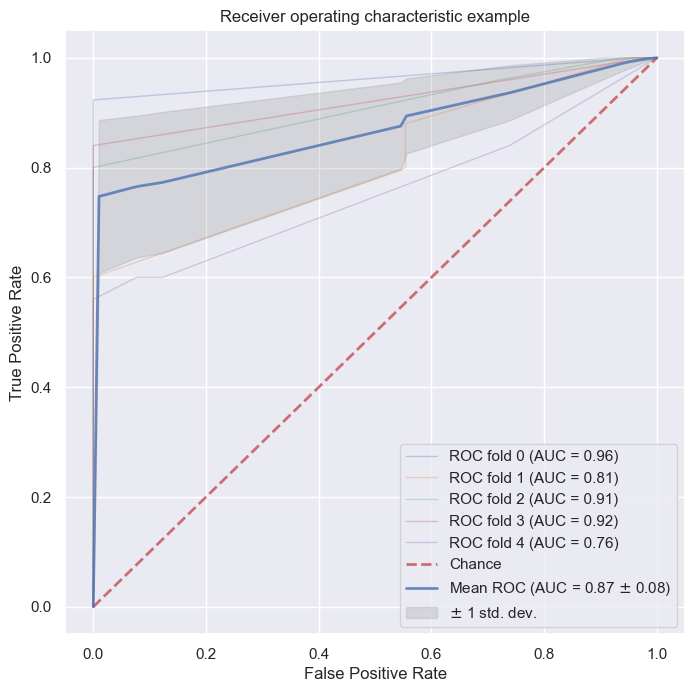

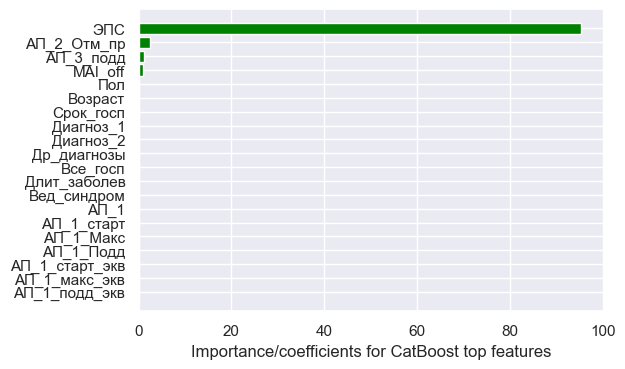

<Figure size 1000x700 with 0 Axes>

In [207]:
X_local = X
cat_cols = CATEGORICAL_COLS

classifier = CatBoostClassifier(
    iterations=2,
    depth=2,
    learning_rate=1,
    loss_function='Logloss',
    verbose=True,
    cat_features=np.array([X_local.columns.get_loc(item) for item in cat_cols]),
) 
cv = StratifiedKFold(n_splits=5)

plot_roc_auc_curve(classifier, cv, X_local.to_numpy(), Y)
plot_important_features(X_local, classifier.feature_importances_, name='CatBoost top features')

# Trying different features

0:	learn: 0.5814273	total: 12.8ms	remaining: 12.8ms
1:	learn: 0.5047353	total: 22.4ms	remaining: 0us
0:	learn: 0.5230804	total: 2.46ms	remaining: 2.46ms
1:	learn: 0.4882423	total: 4.87ms	remaining: 0us
0:	learn: 0.5166766	total: 2.22ms	remaining: 2.22ms
1:	learn: 0.4921412	total: 4.27ms	remaining: 0us
0:	learn: 0.5088803	total: 2.28ms	remaining: 2.28ms
1:	learn: 0.4920444	total: 4.24ms	remaining: 0us
0:	learn: 0.4762667	total: 2.4ms	remaining: 2.4ms
1:	learn: 0.4490273	total: 5.07ms	remaining: 0us


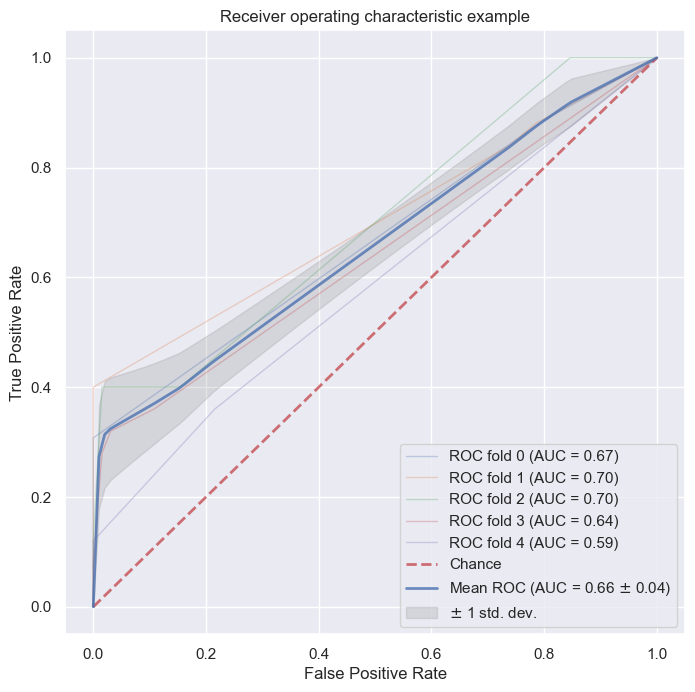

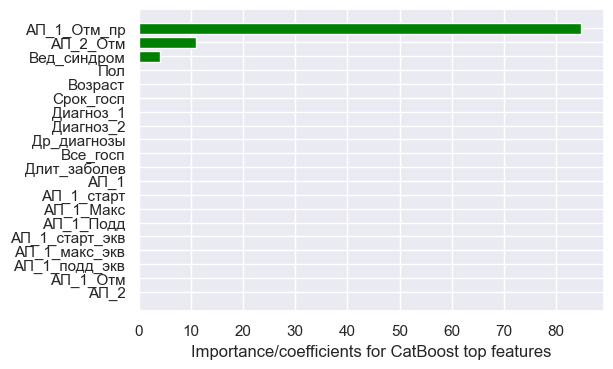

<Figure size 1000x700 with 0 Axes>

In [208]:
columns_to_remove = np.array([
    'ЭПС',
])
cat_cols = np.setdiff1d(CATEGORICAL_COLS, columns_to_remove)
X_local = X.drop(columns=columns_to_remove)


classifier = CatBoostClassifier(
    iterations=2,
    depth=2,
    learning_rate=1,
    loss_function='Logloss',
    verbose=True,
    cat_features=np.array([X_local.columns.get_loc(item) for item in cat_cols]),
) 
cv = StratifiedKFold(n_splits=5)

plot_roc_auc_curve(classifier, cv, X_local.to_numpy(), Y)
plot_important_features(X_local, classifier.feature_importances_, name='CatBoost top features')

# Prediction by drugs count

0:	learn: 0.5693362	total: 784us	remaining: 784us
1:	learn: 0.5616206	total: 1.45ms	remaining: 0us
0:	learn: 0.5675444	total: 523us	remaining: 523us
1:	learn: 0.5580735	total: 871us	remaining: 0us
0:	learn: 0.5627393	total: 295us	remaining: 295us
1:	learn: 0.5517620	total: 750us	remaining: 0us
0:	learn: 0.5672762	total: 279us	remaining: 279us
1:	learn: 0.5577016	total: 654us	remaining: 0us
0:	learn: 0.5535971	total: 296us	remaining: 296us
1:	learn: 0.5382669	total: 690us	remaining: 0us


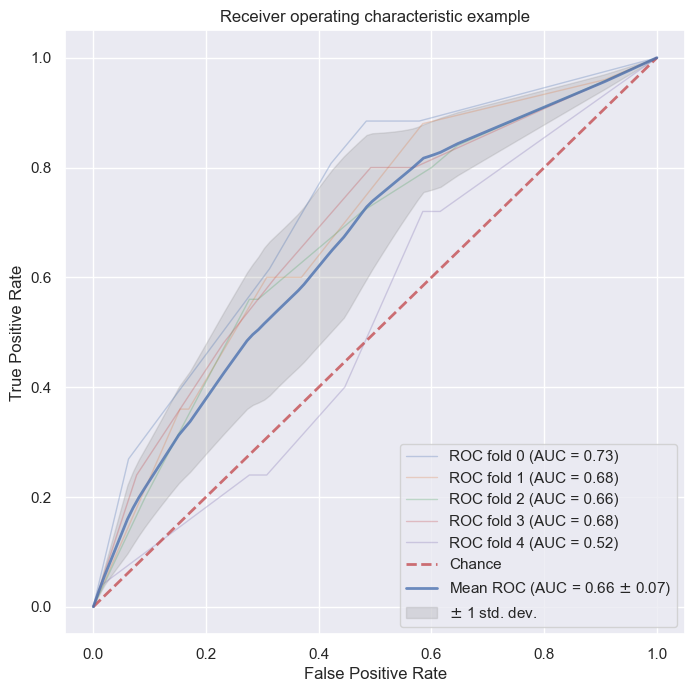

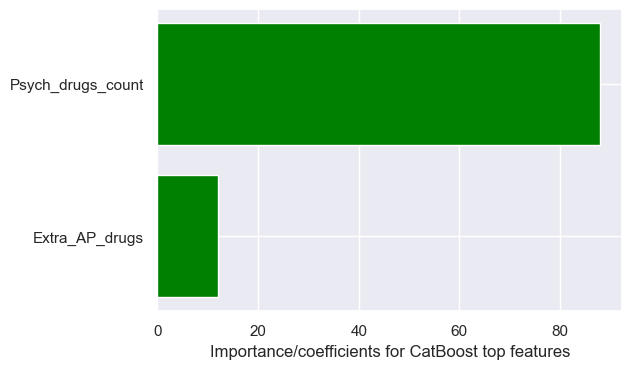

<Figure size 1000x700 with 0 Axes>

In [206]:
X_dr_count = X[[
    'Psych_drugs_count',
    'Extra_AP_drugs',
]]

classifier = CatBoostClassifier(
    iterations=2,
    depth=2,
    learning_rate=1,
    loss_function='Logloss',
    verbose=True,
#     cat_features=np.array([X.columns.get_loc(item) for item in cat_cols]),
) 
cv = StratifiedKFold(n_splits=5)

plot_roc_auc_curve(classifier, cv, X_dr_count.to_numpy(), Y)
plot_important_features(X_dr_count, classifier.feature_importances_, name='CatBoost top features')

# Removing AP cancellation reasons cols

0:	learn: 0.5738344	total: 2.35ms	remaining: 2.35ms
1:	learn: 0.5468608	total: 4.55ms	remaining: 0us
0:	learn: 0.5459466	total: 1.96ms	remaining: 1.96ms
1:	learn: 0.5309096	total: 4.18ms	remaining: 0us
0:	learn: 0.5666038	total: 1.96ms	remaining: 1.96ms
1:	learn: 0.5507420	total: 4.16ms	remaining: 0us
0:	learn: 0.5608330	total: 2.1ms	remaining: 2.1ms
1:	learn: 0.5471770	total: 4.38ms	remaining: 0us
0:	learn: 0.5770915	total: 2.08ms	remaining: 2.08ms
1:	learn: 0.5324417	total: 3.96ms	remaining: 0us


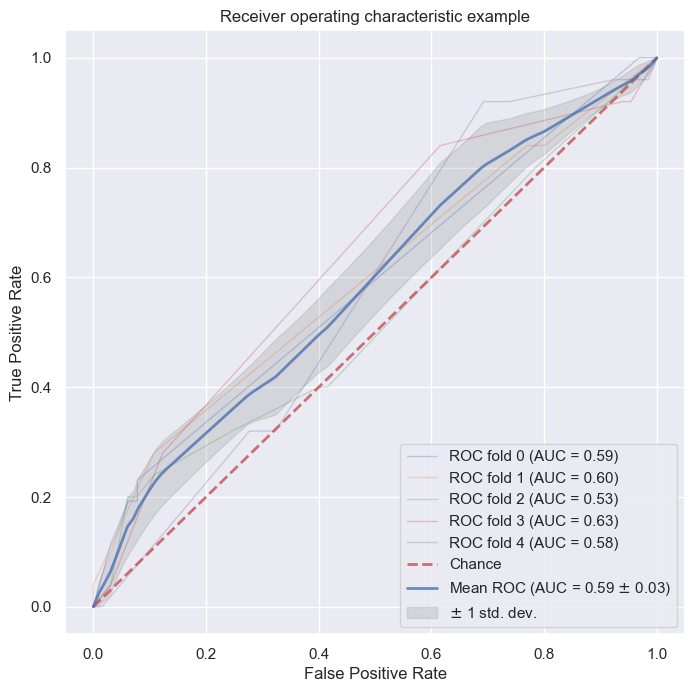

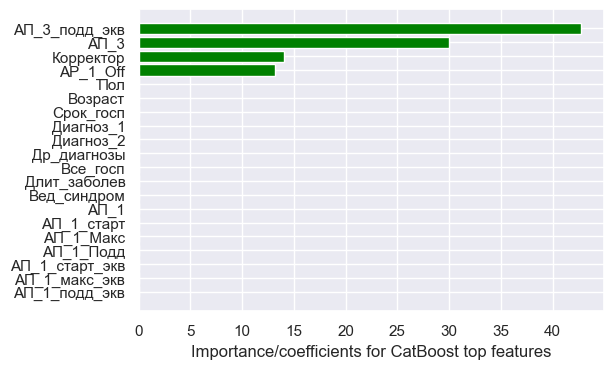

<Figure size 1000x700 with 0 Axes>

In [209]:
columns_to_remove = np.array([
    'АП_1_Отм_пр',
    'АП_2_Отм_пр',
    'АП_3_отм_пр',
    'ЭПС',
])
cat_cols = np.setdiff1d(CATEGORICAL_COLS, columns_to_remove)
X_local = X.drop(columns=columns_to_remove)


classifier = CatBoostClassifier(
    iterations=2,
    depth=2,
    learning_rate=1,
    loss_function='Logloss',
    verbose=True,
    cat_features=np.array([X_local.columns.get_loc(item) for item in cat_cols]),
) 
cv = StratifiedKFold(n_splits=5)

plot_roc_auc_curve(classifier, cv, X_local.to_numpy(), Y)
plot_important_features(X_local, classifier.feature_importances_, name='CatBoost top features')

In [212]:
pearsonr(X['Psych_drugs_count'], Y)

(0.27520936140267477, 2.9053253099539214e-09)